In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [ ]:
fear_greed_df = pd.read_csv('/content/fear_greed_index (1).csv')
print(f"Loaded: {fear_greed_df.shape[0]} rows")

Loaded: 2644 rows


In [ ]:
trader_df = pd.read_csv('/content/historical_data (1).csv',
                        on_bad_lines='skip',
                        engine='python')
print(f"Loaded: {trader_df.shape[0]} rows")


Loaded: 215869 rows


In [ ]:
print(trader_df.columns.tolist())

['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


###DATA CLEANING & PREPROCESSING

In [ ]:
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])
fear_greed_df['timestamp'] = pd.to_datetime(fear_greed_df['timestamp'], unit='s')

In [ ]:
trader_df['datetime'] = pd.to_datetime(trader_df['Timestamp'], unit='ms')
trader_df['date'] = trader_df['datetime'].dt.date
trader_df['date'] = pd.to_datetime(trader_df['date'])
print("Timestamps converted")

Timestamps converted


In [ ]:
trader_df_clean = trader_df.dropna(subset=['Closed PnL', 'Size USD'])

In [ ]:
trader_df_clean['Win'] = (trader_df_clean['Closed PnL'] > 0).astype(int)
trader_df_clean['Loss'] = (trader_df_clean['Closed PnL'] < 0).astype(int)
trader_df_clean['Breakeven'] = (trader_df_clean['Closed PnL'] == 0).astype(int)

In [ ]:
print(f"Cleaned: {len(trader_df_clean)} rows (removed {len(trader_df) - len(trader_df_clean)} rows)")

Cleaned: 215868 rows (removed 1 rows)


In [ ]:
print("\n🔗 Merging datasets...")
merged_df = trader_df_clean.merge(
    fear_greed_df[['date', 'value', 'classification']],
    on='date',
    how='left'
)


🔗 Merging datasets...


In [ ]:
print(f"Merged: {len(merged_df)} rows")
print(f"With sentiment: {merged_df['classification'].notna().sum()}")
print(f"Without sentiment: {merged_df['classification'].isna().sum()}")

Merged: 215868 rows
With sentiment: 187957
Without sentiment: 27911


In [90]:
merged_df = merged_df.dropna(subset=['classification'])
print(f"\n Final dataset: {len(merged_df)} rows for analysis")


 Final dataset: 187957 rows for analysis


In [ ]:
print("\n OVERALL TRADING STATISTICS:")
print("")
print(f"Total Trades: {len(merged_df):,}")
print(f"Total Traders: {merged_df['Account'].nunique():,}")
print(f"Total Coins: {merged_df['Coin'].nunique()}")
print(f"Date Range: {merged_df['date'].min()} to {merged_df['date'].max()}")
print(f"\nTotal PnL: ${merged_df['Closed PnL'].sum():,.2f}")
print(f"Average PnL: ${merged_df['Closed PnL'].mean():,.2f}")
print(f"Median PnL: ${merged_df['Closed PnL'].median():,.2f}")
print(f"\nWin Rate: {(merged_df['Win'].sum() / len(merged_df) * 100):.2f}%")
print(f"Loss Rate: {(merged_df['Loss'].sum() / len(merged_df) * 100):.2f}%")


 OVERALL TRADING STATISTICS:

Total Trades: 187,957
Total Traders: 32
Total Coins: 239
Date Range: 2023-03-28 00:00:00 to 2025-02-19 00:00:00

Total PnL: $10,437,705.59
Average PnL: $55.53
Median PnL: $0.00

Win Rate: 41.89%
Loss Rate: 7.40%


In [ ]:
print("\n TOP 10 TRADED COINS:")
print(merged_df['Coin'].value_counts().head(10))


 TOP 10 TRADED COINS:
Coin
HYPE         62462
@107         27386
BTC          21332
ETH          11828
SOL           8681
FARTCOIN      3431
MELANIA       3330
PURR/USDC     2769
SUI           1847
XRP           1825
Name: count, dtype: int64


In [ ]:
print("\n SENTIMENT DISTRIBUTION:")
print(merged_df['classification'].value_counts())


 SENTIMENT DISTRIBUTION:
classification
Fear             134739
Greed             37455
Extreme Greed      8622
Neutral            7141
Name: count, dtype: int64


In [ ]:
sentiment_analysis = merged_df.groupby('classification').agg({
    'Closed PnL': ['count', 'sum', 'mean', 'median', 'std'],
    'Size USD': ['mean', 'median'],
    'Win': 'sum',
    'Loss': 'sum',
    'Fee': 'sum'
}).round(2)


In [ ]:
print("\n DETAILED SENTIMENT ANALYSIS:")
print(sentiment_analysis)


 DETAILED SENTIMENT ANALYSIS:
               Closed PnL                                    Size USD  \
                    count         sum   mean median      std     mean   
classification                                                          
Extreme Greed        8622   170758.54  19.80    0.0   280.85  6244.51   
Fear               134739  6902726.63  51.23    0.0   913.93  5242.13   
Greed               37455  3205478.05  85.58    0.0  1131.58  3412.25   
Neutral              7141   158742.38  22.23    0.0   633.70  3058.85   

                           Win  Loss        Fee  
                 median    sum   sum        sum  
classification                                   
Extreme Greed   1247.55   3805  1305   10167.87  
Fear             604.42  56143  8979  145316.19  
Greed            505.64  16514  3069   27241.94  
Neutral          554.16   2265   547    8743.88  


In [ ]:
print("\n win Rate by sentiment:")
print("-" * 80)
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
for sentiment in sentiment_order:
    if sentiment in merged_df['classification'].values:
        sentiment_data = merged_df[merged_df['classification'] == sentiment]
        win_rate = (sentiment_data['Win'].sum() / len(sentiment_data)) * 100
        total_trades = len(sentiment_data)
        avg_pnl = sentiment_data['Closed PnL'].mean()
        total_pnl = sentiment_data['Closed PnL'].sum()

        print(f"{sentiment:15s} | Trades: {total_trades:6,} | Win Rate: {win_rate:5.2f}% | "
              f"Avg PnL: ${avg_pnl:8.2f} | Total: ${total_pnl:12,.2f}")


 win Rate by sentiment:
--------------------------------------------------------------------------------
Fear            | Trades: 134,739 | Win Rate: 41.67% | Avg PnL: $   51.23 | Total: $6,902,726.63
Neutral         | Trades:  7,141 | Win Rate: 31.72% | Avg PnL: $   22.23 | Total: $  158,742.38
Greed           | Trades: 37,455 | Win Rate: 44.09% | Avg PnL: $   85.58 | Total: $3,205,478.05
Extreme Greed   | Trades:  8,622 | Win Rate: 44.13% | Avg PnL: $   19.80 | Total: $  170,758.54


Text(0.5, 0.98, 'Trader Performance Analysis by Market Sentiment')

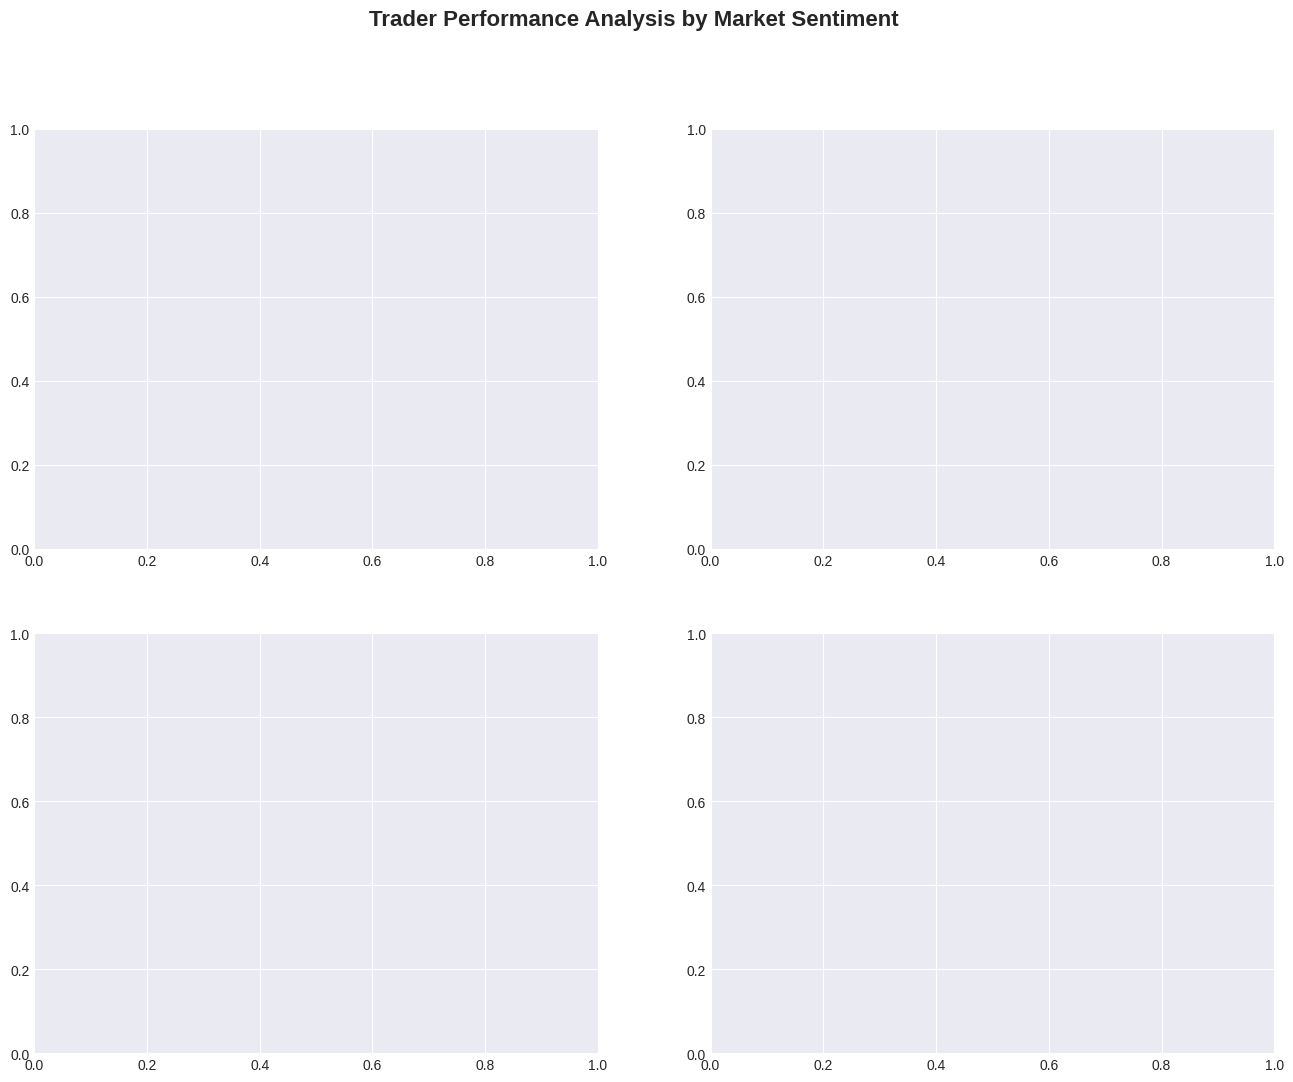

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Trader Performance Analysis by Market Sentiment', fontsize=16, fontweight='bold')

#### Average PnL

In [ ]:
avg_pnl = merged_df.groupby('classification')['Closed PnL'].mean().reindex(sentiment_order)
axes[0, 0].bar(avg_pnl.index, avg_pnl.values, color=['#d62728', '#ff7f0e', '#7f7f7f', '#2ca02c', '#1f77b4'])
axes[0, 0].set_title('Average PnL by Sentiment', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Average PnL ($)')
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(avg_pnl.values):
    if not pd.isna(v):
        axes[0, 0].text(i, v, f'${v:.2f}', ha='center', va='bottom' if v > 0 else 'top')

### Win rate

In [ ]:
win_rates = []
for sentiment in sentiment_order:
    sentiment_data = merged_df[merged_df['classification'] == sentiment]
    win_rate = (sentiment_data['Win'].sum() / len(sentiment_data)) * 100 if len(sentiment_data) > 0 else 0
    win_rates.append(win_rate)

axes[0, 1].bar(sentiment_order, win_rates, color=['#d62728', '#ff7f0e', '#7f7f7f', '#2ca02c', '#1f77b4'])
axes[0, 1].set_title('Win Rate by Sentiment', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Win Rate (%)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(win_rates):
    axes[0, 1].text(i, v, f'{v:.1f}%', ha='center', va='bottom')

###---Trade volume

In [ ]:
trade_counts = merged_df['classification'].value_counts().reindex(sentiment_order)
axes[1, 0].bar(trade_counts.index, trade_counts.values, color=['#d62728', '#ff7f0e', '#7f7f7f', '#2ca02c', '#1f77b4'])
axes[1, 0].set_title('Number of Trades by Sentiment', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Number of Trades')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(trade_counts.values):
    if not pd.isna(v):
        axes[1, 0].text(i, v, f'{int(v):,}', ha='center', va='bottom')

###position Size

In [ ]:
avg_size = merged_df.groupby('classification')['Size USD'].mean().reindex(sentiment_order)
axes[1, 1].bar(avg_size.index, avg_size.values, color=['#d62728', '#ff7f0e', '#7f7f7f', '#2ca02c', '#1f77b4'])
axes[1, 1].set_title('Average Position Size by Sentiment', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Average Position Size ($)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(avg_size.values):
    if not pd.isna(v):
        axes[1, 1].text(i, v, f'${v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('sentiment_performance_overview.png', dpi=300, bbox_inches='tight')


print(" Saved: sentiment_performance_overview.png")
plt.show()


 Saved: sentiment_performance_overview.png


<Figure size 640x480 with 0 Axes>

###Visualization 2: PnL Distribution



 Creating visualization 2/5...
 Saved: pnl_distribution_boxplot.png


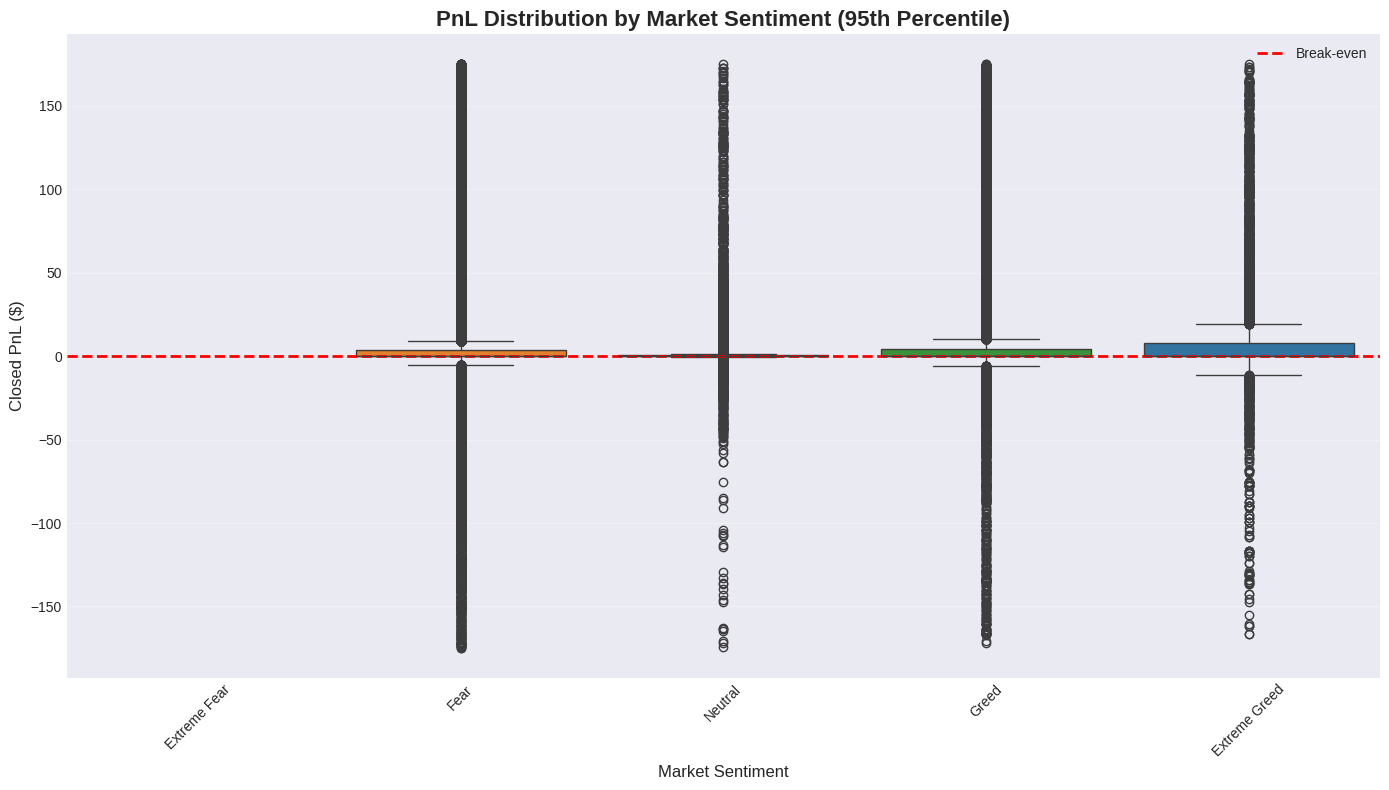

In [ ]:
print("\n Creating visualization 2/5...")
fig, ax = plt.subplots(figsize=(14, 8))
pnl_limit = merged_df['Closed PnL'].quantile(0.95)
filtered_df = merged_df[merged_df['Closed PnL'].abs() <= pnl_limit]

sns.boxplot(data=filtered_df, x='classification', y='Closed PnL',
            order=sentiment_order, palette=['#d62728', '#ff7f0e', '#7f7f7f', '#2ca02c', '#1f77b4'])
ax.set_title('PnL Distribution by Market Sentiment (95th Percentile)', fontsize=16, fontweight='bold')
ax.set_xlabel('Market Sentiment', fontsize=12)
ax.set_ylabel('Closed PnL ($)', fontsize=12)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Break-even')
ax.tick_params(axis='x', rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('pnl_distribution_boxplot.png', dpi=300, bbox_inches='tight')
print(" Saved: pnl_distribution_boxplot.png")
plt.show()

###Visualization 3: Time Series

Saved: time_series_analysis.png


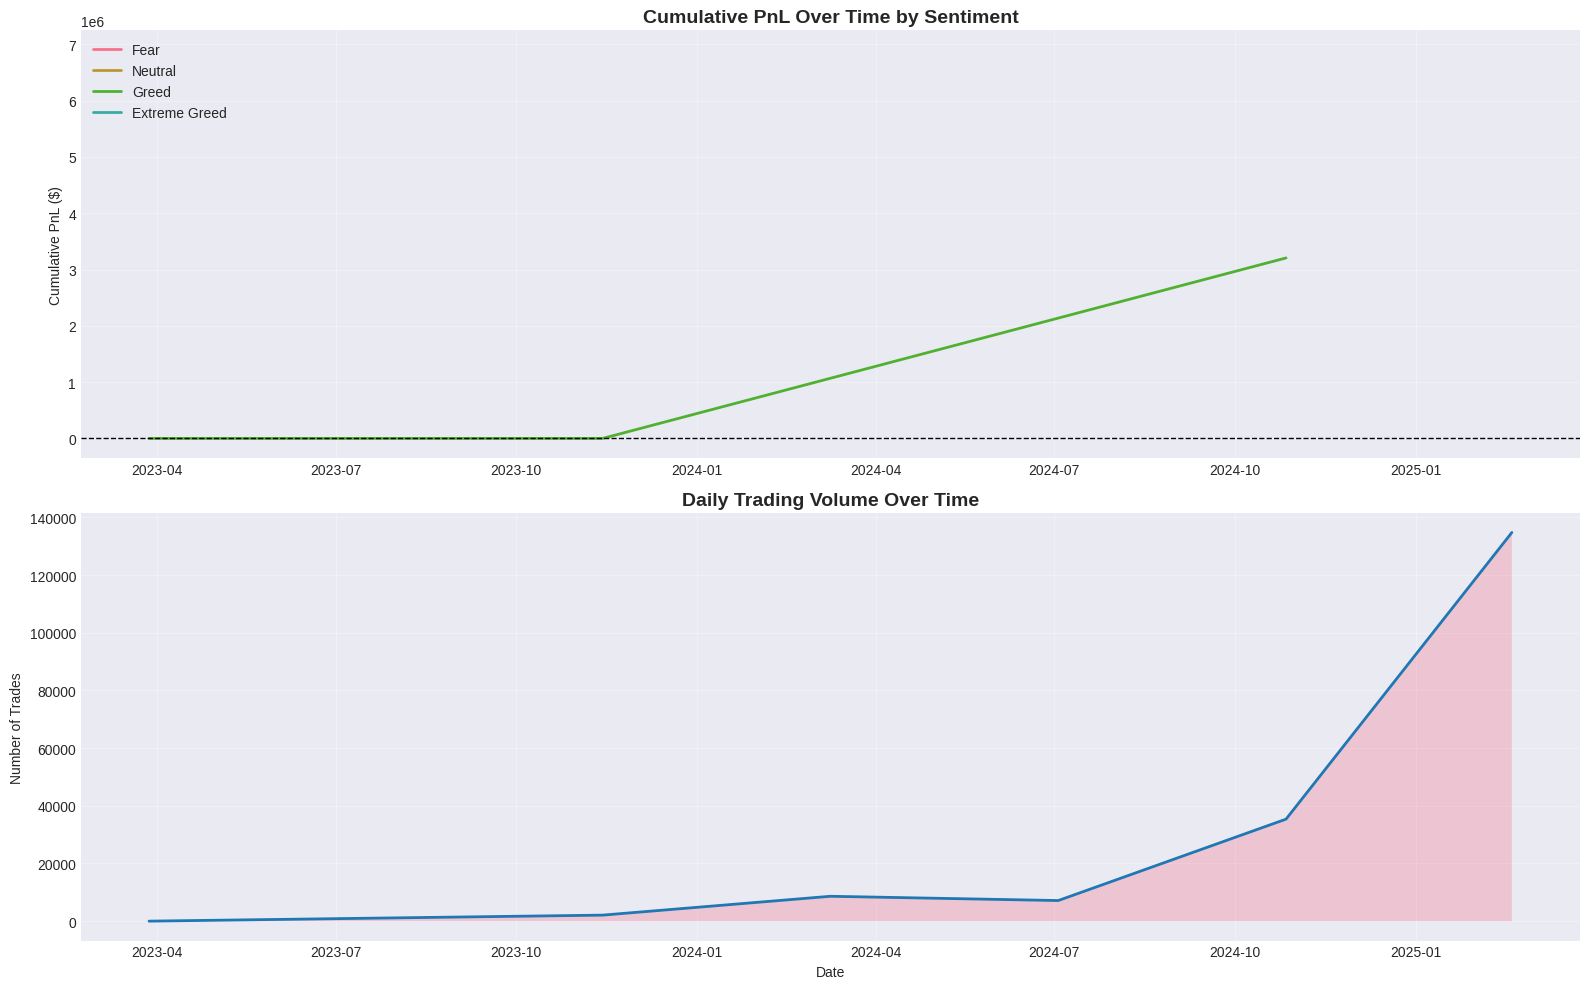

In [91]:

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

daily_pnl = merged_df.groupby(['date', 'classification'])['Closed PnL'].sum().reset_index()

for sentiment in sentiment_order:
    sentiment_data = daily_pnl[daily_pnl['classification'] == sentiment].sort_values('date')
    if len(sentiment_data) > 0:
        sentiment_data['cumulative_pnl'] = sentiment_data['Closed PnL'].cumsum()
        axes[0].plot(sentiment_data['date'], sentiment_data['cumulative_pnl'], label=sentiment, linewidth=2)

axes[0].set_title('Cumulative PnL Over Time by Sentiment', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cumulative PnL ($)')
axes[0].legend(loc='best')
axes[0].grid(alpha=0.3)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)

daily_counts = merged_df.groupby('date').size().reset_index(name='count')
axes[1].plot(daily_counts['date'], daily_counts['count'], linewidth=2, color='#1f77b4')
axes[1].fill_between(daily_counts['date'], daily_counts['count'], alpha=0.3)
axes[1].set_title('Daily Trading Volume Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Trades')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('time_series_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: time_series_analysis.png")
plt.show()

###Visualization 4: Coin Performance Heatmap

Saved: coin_sentiment_heatmap.png


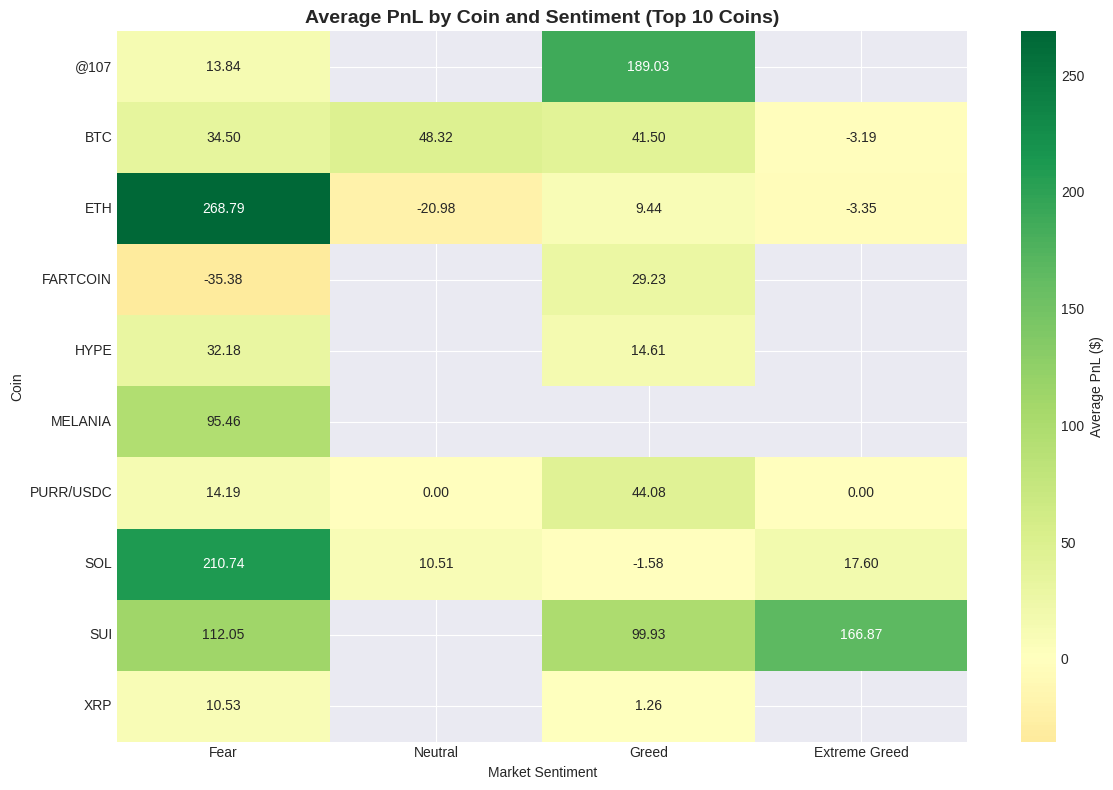

In [92]:

top_10_coins = merged_df['Coin'].value_counts().head(10).index

coin_sentiment_pnl = merged_df[merged_df['Coin'].isin(top_10_coins)].pivot_table(
    values='Closed PnL',
    index='Coin',
    columns='classification',
    aggfunc='mean'
)
available_sentiments = [s for s in sentiment_order if s in coin_sentiment_pnl.columns]
coin_sentiment_pnl = coin_sentiment_pnl[available_sentiments]

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(coin_sentiment_pnl, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0, cbar_kws={'label': 'Average PnL ($)'})
ax.set_title('Average PnL by Coin and Sentiment (Top 10 Coins)', fontsize=14, fontweight='bold')
ax.set_xlabel('Market Sentiment')
ax.set_ylabel('Coin')

plt.tight_layout()
plt.savefig('coin_sentiment_heatmap.png', dpi=300, bbox_inches='tight')
print("Saved: coin_sentiment_heatmap.png")
plt.show()


##Visualization 5: Sentiment Score Correlation


 Creating visualization 5/5...
Saved: sentiment_score_correlation.png


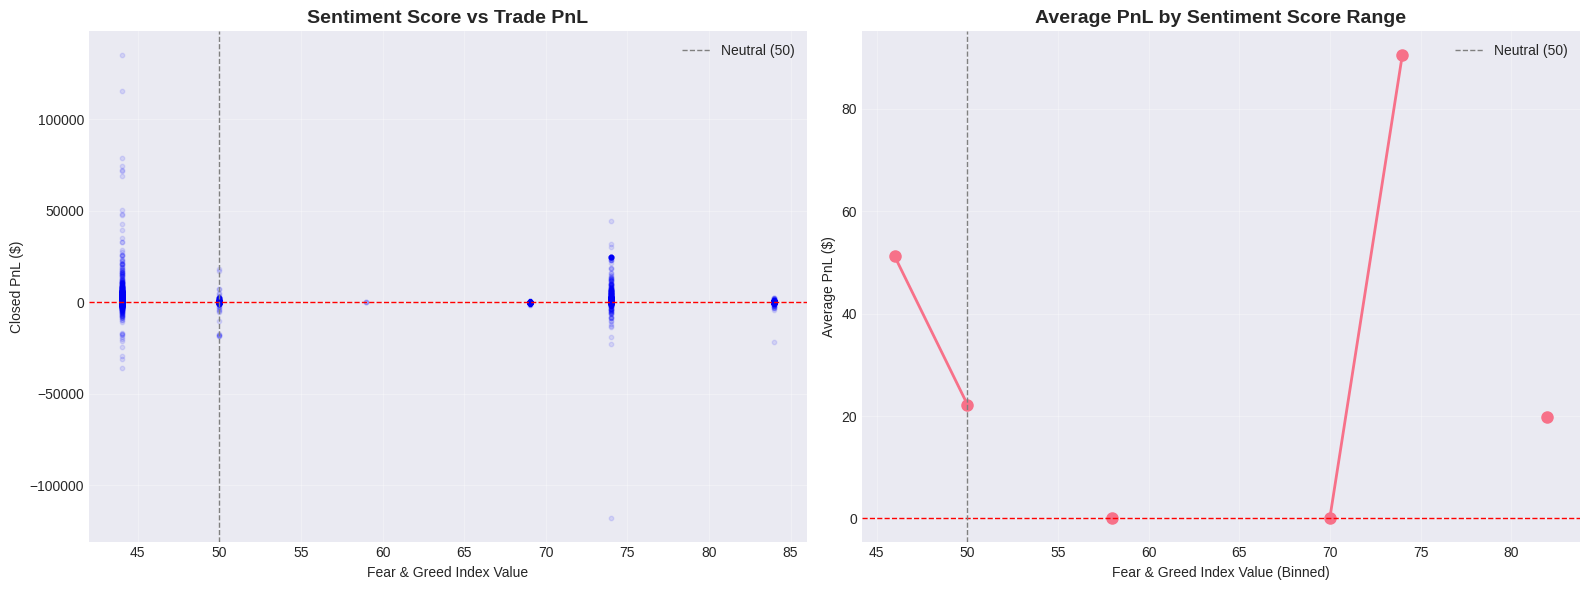

In [ ]:
print("\n Creating visualization 5/5...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(merged_df['value'], merged_df['Closed PnL'], alpha=0.1, s=10, color='blue')
axes[0].set_title('Sentiment Score vs Trade PnL', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fear & Greed Index Value')
axes[0].set_ylabel('Closed PnL ($)')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].axvline(x=50, color='gray', linestyle='--', linewidth=1, label='Neutral (50)')
axes[0].legend()
axes[0].grid(alpha=0.3)

merged_df['value_bin'] = pd.cut(merged_df['value'], bins=10)
binned_pnl = merged_df.groupby('value_bin')['Closed PnL'].mean()
bin_centers = [interval.mid for interval in binned_pnl.index]

axes[1].plot(bin_centers, binned_pnl.values, marker='o', linewidth=2, markersize=8)
axes[1].set_title('Average PnL by Sentiment Score Range', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fear & Greed Index Value (Binned)')
axes[1].set_ylabel('Average PnL ($)')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].axvline(x=50, color='gray', linestyle='--', linewidth=1, label='Neutral (50)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('sentiment_score_correlation.png', dpi=300, bbox_inches='tight')
print("Saved: sentiment_score_correlation.png")
plt.show()

In [ ]:
### Results

In [ ]:
merged_df.to_csv('merged_trader_sentiment_data.csv', index=False)
print(" Saved: merged_trader_sentiment_data.csv")

 Saved: merged_trader_sentiment_data.csv


In [ ]:
summary_stats = merged_df.groupby('classification').agg({
    'Closed PnL': ['count', 'sum', 'mean', 'median'],
    'Size USD': ['mean', 'median'],
    'Win': 'sum',
    'Loss': 'sum'
}).round(2)
summary_stats.to_csv('sentiment_summary_stats.csv')
print(" Saved: sentiment_summary_stats.csv")

 Saved: sentiment_summary_stats.csv


In [ ]:
insights = []
best_sentiment = avg_pnl.idxmax()
best_pnl_val = avg_pnl.max()
insights.append(f"1. BEST SENTIMENT: '{best_sentiment}' with avg PnL of ${best_pnl_val:.2f}")

In [ ]:

best_wr_idx = np.argmax(win_rates)
best_wr_sentiment = sentiment_order[best_wr_idx]
best_wr_value = win_rates[best_wr_idx]
insights.append(f"2. HIGHEST WIN RATE: '{best_wr_sentiment}' has {best_wr_value:.2f}% win rate")


In [ ]:
most_active = trade_counts.idxmax()
most_active_count = trade_counts.max()
insights.append(f"3. MOST ACTIVE: '{most_active}' has {int(most_active_count):,} trades")

In [ ]:
max_size_sentiment = avg_size.idxmax()
max_size_value = avg_size.max()
insights.append(f"4. LARGEST POSITIONS: '{max_size_sentiment}' (${max_size_value:.2f})")

In [ ]:

total_profitable = (merged_df.groupby('classification')['Closed PnL'].sum() > 0).sum()
insights.append(f"5. PROFITABILITY: {total_profitable}/5 sentiment categories are profitable")

In [ ]:
for insight in insights:
    print(f"\n{insight}")


1. BEST SENTIMENT: 'Greed' with avg PnL of $85.58

2. HIGHEST WIN RATE: 'Extreme Greed' has 44.13% win rate

3. MOST ACTIVE: 'Fear' has 134,739 trades

4. LARGEST POSITIONS: 'Extreme Greed' ($6244.51)

5. PROFITABILITY: 4/5 sentiment categories are profitable


In [ ]:
with open('key_insights.txt', 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("KEY INSIGHTS - Crypto Trader Behavior & Market Sentiment\n")
    f.write("=" * 80 + "\n\n")
    for insight in insights:
        f.write(insight + "\n")

print("\n Saved: key_insights.txt")


 Saved: key_insights.txt
